<a href="https://colab.research.google.com/github/leedujin/Dacon_4D_structure/blob/main/grad_cam_%EB%91%90%EC%A7%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.chdir("/content")

# pt 파일 업로드, grad_cam 확인해볼 사진 업로드

In [ ]:
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models

class FeatureExtractor(): 

    def __init__(self, model, blob_name, target_layers):
        self.model = model
        self.blob_name = blob_name
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for idx, module in self.model.backbone._modules.items(): # 저장
            if idx != self.blob_name:
                try:
                    x = module(x)
                except:
                    x = x.view(x.size(0), -1)
                    x = module(x)
            else:
                for name, block in enumerate(getattr(self.model.backbone, self.blob_name)):
                    x = block(x)
                    if str(name) in self.target_layers:
                        x.register_hook(self.save_gradient)
                        outputs += [x]
                        
        x = self.model.classifier(x)
        return outputs, x

def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    inputs = preprocessed_img.requires_grad_(True)
    return inputs


def show_cams(img, mask_dic):
    for name, mask in mask_dic.items():
        show_cam_on_image(img, mask, name)
    
def show_cam_on_image(img, mask, name):
    global target_index
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam{}_{}.jpg".format(name, target_index), np.uint8(255 * cam))

class GradCam:
    def __init__(self, model, blob_name, target_layer_names, use_cuda):
        self.model = model
        self.target_layer_names = target_layer_names
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.extractor = FeatureExtractor(self.model, blob_name, target_layer_names)

    def __call__(self, inputs, index=None):
        cam_dic = {}
        if self.cuda:
            features, output = self.extractor(inputs.cuda())
        else:
            features, output = self.extractor(inputs)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
        self.model.backbone.zero_grad()
        one_hot.backward()
        self.model.backbone.zero_grad()
        for idx, feature in enumerate(features): #
            grads_val = self.extractor.gradients[len(features)-1-idx].cpu().data.numpy()
            target = features[idx]
            target = target.cpu().data.numpy()[0, :]
            weights = np.mean(grads_val, axis=(2, 3))[0, :]
            cam = np.zeros(target.shape[1:], dtype=np.float32)
            for i, w in enumerate(weights):
                cam += w * target[i, :, :]
            cam = np.maximum(cam, 0)
            cam = cv2.resize(cam, (224, 224))
            cam = cam - np.min(cam)
            cam = cam / np.max(cam)
            cam_dic[self.target_layer_names[idx]] = cam
        return cam_dic


class GuidedBackpropReLU(Function):

    @staticmethod
    def forward(self, i):
        positive_mask = (i > 0).type_as(i)
        output = torch.addcmul(torch.zeros(i.size()).type_as(i), i, positive_mask)
        self.save_for_backward(i)
        return output

    @staticmethod
    def backward(self, grad_output):
        i = self.saved_tensors[0]
        grad_input = None
        positive_mask_1 = (i > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(i.size()).type_as(i),
                                   torch.addcmul(torch.zeros(i.size()).type_as(i), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input

class GuidedBackpropSwish(Function):

    @staticmethod
    def forward(self, i):
        result = i * torch.sigmoid(i)
        self.save_for_backward(i)
        return result

    @staticmethod
    def backward(self, grad_output):
        i = self.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        positive_mask_1 = (i > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i))) * positive_mask_1 * positive_mask_2
        return grad_input
        
class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda, activation_layer_name = 'ReLU'):
        self.model = model.backbone
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        if activation_layer_name == 'MemoryEfficientSwish':
            fb_func = GuidedBackpropSwish.apply
        else:
            fb_func = GuidedBackpropReLU.apply
        for idx0, module0 in self.model._modules.items():
            module0 = self.model._modules[idx0]
            if module0.__class__.__name__ == activation_layer_name:
                self.model._modules[idx0] = fb_func
            for idx1, _ in module0._modules.items():
                module1 = module0._modules[idx1]
                if module1.__class__.__name__ == activation_layer_name:
                    self.model._modules[idx0]._modules[idx1] = fb_func
                    continue
                for idx2, _ in module1._modules.items():
                    module2 = module1._modules[idx2]
                    if module2.__class__.__name__ == activation_layer_name:
                        self.model._modules[idx0]._modules[idx1]._modules[idx2] = fb_func
                    
    def forward(self, inputs):
        return self.model(inputs)

    def __call__(self, inputs, index=None):
        if self.cuda:
            output = self.forward(inputs.cuda())
        else:
            output = self.forward(inputs)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
        one_hot.backward()
        gradient = inputs.grad.cpu().data.numpy()
        gradient = gradient[0, :, :, :]
        return gradient


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument('--image-path', type=str, default='./assets/dog.jpg',
                        help='Input image path')
    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print("Using GPU for acceleration")
    else:
        print("Using CPU for computation")

    return args

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

def show_gbs(inputs, gb_model, target_index, mask_dic):
    gb = gb_model(inputs, index=target_index)
    gb = gb.transpose((1, 2, 0))
    for idx, mask in mask_dic.items():
        cam_mask = cv2.merge([mask, mask, mask])
        cam_gb = deprocess_image(cam_mask*gb)
        cv2.imwrite('cam_gb{}_{}.jpg'.format(idx, target_index), cam_gb)
    cv2.imwrite('gb.jpg', deprocess_image(gb))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('/')

import torch
import cv2
import numpy as np
from torchvision import models

class BaseModel(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b3(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
        ######
        
    def forward(self, x):
        x = self.backbone(x)
        
        ######
        
        x = F.sigmoid(self.classifier(x))
        return x

In [ ]:
loaded_model = torch.load("/content/0118_ENB3_model(public_0.92).pt", map_location = torch.device("cpu"))
loaded_model

BaseModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_

In [ ]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in loaded_model.state_dict():
    print(param_tensor, "\t", loaded_model.state_dict()[param_tensor].size())

Model's state_dict:
backbone.features.0.0.weight 	 torch.Size([40, 3, 3, 3])
backbone.features.0.1.weight 	 torch.Size([40])
backbone.features.0.1.bias 	 torch.Size([40])
backbone.features.0.1.running_mean 	 torch.Size([40])
backbone.features.0.1.running_var 	 torch.Size([40])
backbone.features.0.1.num_batches_tracked 	 torch.Size([])
backbone.features.1.0.block.0.0.weight 	 torch.Size([40, 1, 3, 3])
backbone.features.1.0.block.0.1.weight 	 torch.Size([40])
backbone.features.1.0.block.0.1.bias 	 torch.Size([40])
backbone.features.1.0.block.0.1.running_mean 	 torch.Size([40])
backbone.features.1.0.block.0.1.running_var 	 torch.Size([40])
backbone.features.1.0.block.0.1.num_batches_tracked 	 torch.Size([])
backbone.features.1.0.block.1.fc1.weight 	 torch.Size([10, 40, 1, 1])
backbone.features.1.0.block.1.fc1.bias 	 torch.Size([10])
backbone.features.1.0.block.1.fc2.weight 	 torch.Size([40, 10, 1, 1])
backbone.features.1.0.block.1.fc2.bias 	 torch.Size([40])
backbone.features.1.0.block.2.

In [ ]:
block_classes = {
    0 : "A",
    1 : "B",
    2 : "C",
    3 : "D",
    4 : "E",
    5 : "F",
    6 : "G",
    7 : "H",
    8 : "I",
    9 : "J"
}

In [ ]:
grad_cam = GradCam(model=loaded_model, blob_name = 'features', target_layer_names=["8"], use_cuda= False)
img = cv2.imread('/content/new_train_17743.png', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img)
# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.

target_index = [1, 2, 3, 6, 7, 9]
mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic)
gb_model = GuidedBackpropReLUModel(model=loaded_model, activation_layer_name = 'MemoryEfficientSwish', use_cuda=False)
show_gbs(inputs, gb_model, target_index, mask_dic)
show_cams

<function __main__.show_cams(img, mask_dic)>

In [ ]:
grad_cam = GradCam(model=loaded_model, blob_name = 'features', target_layer_names=["8"], use_cuda= False)
img = cv2.imread('/content/new_train_17743.png', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img)
# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.

target_index = [2]
mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic)
gb_model = GuidedBackpropReLUModel(model=loaded_model, activation_layer_name = 'MemoryEfficientSwish', use_cuda=False)
show_gbs(inputs, gb_model, target_index, mask_dic)
show_cams

<function __main__.show_cams(img, mask_dic)>

In [ ]:
grad_cam = GradCam(model=loaded_model, blob_name = 'features', target_layer_names=["8"], use_cuda= False)
img = cv2.imread('/content/new_train_17743.png', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img)
# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.

target_index = [3]
mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic)
gb_model = GuidedBackpropReLUModel(model=loaded_model, activation_layer_name = 'MemoryEfficientSwish', use_cuda=False)
show_gbs(inputs, gb_model, target_index, mask_dic)
show_cams

<function __main__.show_cams(img, mask_dic)>

In [ ]:
grad_cam = GradCam(model=loaded_model, blob_name = 'features', target_layer_names=["8"], use_cuda= False)
img = cv2.imread('/content/new_train_17743.png', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img)
# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.

target_index = [6]
mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic)
gb_model = GuidedBackpropReLUModel(model=loaded_model, activation_layer_name = 'MemoryEfficientSwish', use_cuda=False)
show_gbs(inputs, gb_model, target_index, mask_dic)
show_cams

<function __main__.show_cams(img, mask_dic)>

In [ ]:
grad_cam = GradCam(model=loaded_model, blob_name = 'features', target_layer_names=["8"], use_cuda= False)
img = cv2.imread('/content/new_train_17743.png', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img)
# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.

target_index = [7]
mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic)
gb_model = GuidedBackpropReLUModel(model=loaded_model, activation_layer_name = 'MemoryEfficientSwish', use_cuda=False)
show_gbs(inputs, gb_model, target_index, mask_dic)
show_cams

<function __main__.show_cams(img, mask_dic)>

In [ ]:
grad_cam = GradCam(model=loaded_model, blob_name = 'features', target_layer_names=["8"], use_cuda= False)
img = cv2.imread('/content/new_train_17743.png', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img)
# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.

target_index = [9]
mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic)
gb_model = GuidedBackpropReLUModel(model=loaded_model, activation_layer_name = 'MemoryEfficientSwish', use_cuda=False)
show_gbs(inputs, gb_model, target_index, mask_dic)
show_cams

<function __main__.show_cams(img, mask_dic)>

In [ ]:
img_b = cv2.imread("/content/cam8_[1].jpg")
img_c = cv2.imread("/content/cam8_[2].jpg")
img_d = cv2.imread("/content/cam8_[3].jpg")
img_g = cv2.imread("/content/cam8_[6].jpg")
img_h = cv2.imread("/content/cam8_[7].jpg")
img_j = cv2.imread("/content/cam8_[9].jpg")
gb_b = cv2.imread("/content/cam_gb8_[1].jpg")
gb_c = cv2.imread("/content/cam_gb8_[2].jpg")
gb_d = cv2.imread("/content/cam_gb8_[3].jpg")
gb_g = cv2.imread("/content/cam_gb8_[6].jpg")
gb_h = cv2.imread("/content/cam_gb8_[7].jpg")
gb_j = cv2.imread("/content/cam_gb8_[9].jpg")

img_list = [img_b, img_c, img_d, img_g, img_h, img_j, gb_b, gb_c, gb_d, gb_g, gb_h, gb_j]
len(img_list)

12

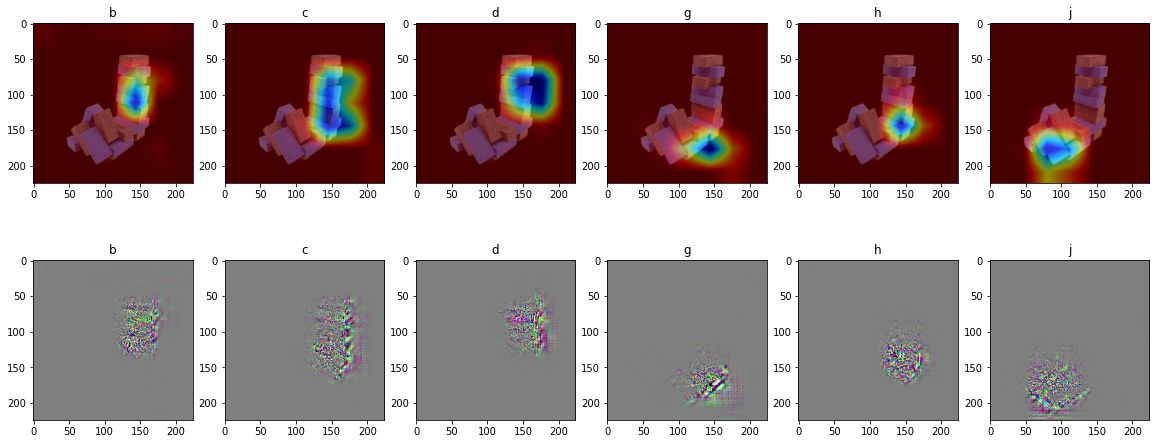

In [ ]:
import matplotlib.pyplot as plt
label_list = ["b", "c", "d", "g", "h", "j", "b", "c", "d", "g", "h", "j"]
plt.figure(figsize = (20, 8))
for i in range(12):
  plt.subplot(2, 6, i+1)
  plt.title("{}".format(label_list[i]))
  plt.imshow(img_list[i])
plt.show()